In [1]:
import pandas as pd
import scanpy as sc
#import seaborn as sb

from matplotlib import rcParams

In [2]:
import sys
sys.path.append('../..')
import tcr_embedding.utils_training as utils
import config.constants_10x as const

from tcr_embedding.models.pertubation_prediction import predict_pertubation
from tcr_embedding.evaluation.PertubationPrediction import evaluate_pertubation

In [3]:
import seaborn as sb
sb.set(context='paper', style='whitegrid')
sb.set_palette('colorblind')

### Utility Functions

In [4]:
def load_model(adata, dataset, model, cell_type):
    path_model = f'saved_models/journal/{dataset.upper()}_ct2/{model}/scGen_{dataset}_{cell_type}_{model}.pt'
    model = utils.load_model(adata, path_model)
    return model

In [5]:
def load_modulation_data(dataset):
    adata = utils.load_data(dataset)
    return adata

### BCC dataset (Yost et al.)

In [6]:
dataset = 'bcc'
cell_type_names = [
    'CD4_T_cells',
    'CD8_mem_T_cells',
    'Tregs',
    'CD8_act_T_cells',
    'CD8_ex_T_cells',
    'Tcell_prolif'
]

In [7]:
data = load_modulation_data(dataset)
sc.tl.rank_genes_groups(data, 'cluster', n_genes=100, method='wilcoxon')
degs = data.uns['rank_genes_groups']['names']

model_names = []
metrics = []
cell_types = []
scores = []

for ct in cell_type_names:
    print(ct)
    for model_name in ['rna', 'moe']:
        data_tmp = data.copy()
        model = load_model(data_tmp, dataset, model_name, ct)
        
        latent = model.get_latent(data_tmp, metadata=['patient', 'treatment', 'cluster'])

        mask_train = latent.obs['cluster'] != ct
        latent_train = latent[mask_train]
        latent_val = latent[~mask_train]
        mask_val_pre = latent_val.obs['treatment'] == 'pre'
        latent_val_pre = latent_val[mask_val_pre]

        if len(latent_val_pre)== 0:
            break
        pred_val_post = predict_pertubation(latent_train, latent_val_pre, model,
                                            'treatment', 'pre', var_names=data_tmp.var_names, col_type='cluster')       
        
        train_tmp = data_tmp[data_tmp.obs['cluster']==ct]
        summary = evaluate_pertubation(train_tmp, pred_val_post, 'cluster',
                                     'treatment', indicator='pre', gene_set=degs[ct])

        model_names += [model_name] * 2
        cell_types += [ct] * 2
        metrics += ['R_squared', 'R_squared_top_100']
        scores += [summary['all_genes']['r_squared'], 
                   summary['top_100_genes']['r_squared']]
    
    data_tmp = data.copy()
    train_tmp = data_tmp[data_tmp.obs['cluster']==ct]
    pred_val_pre = train_tmp[train_tmp.obs['treatment']=='pre'].copy()
    
    summary = evaluate_pertubation(train_tmp, pred_val_pre, 'cluster',
                                     'treatment', indicator='pre', gene_set=degs[ct])
    
    model_names += ['pre'] * 2
    cell_types += [ct] * 2
    metrics += ['R_squared', 'R_squared_top_100']
    scores += [summary['all_genes']['r_squared'], 
               summary['top_100_genes']['r_squared']]


results_bcc = {
    'model': model_names,
    'cell type': cell_types,
    'metric': metrics,
    'score': scores,
}
results_bcc = pd.DataFrame(results_bcc)
results_bcc.to_csv('results/performance_bcc_ct.csv')
results_bcc

CD4_T_cells
CD8_mem_T_cells
Tregs
CD8_act_T_cells
CD8_ex_T_cells
Tcell_prolif


,model,cell type,metric,score
0,rna,CD4_T_cells,R_squared,0.976692
1,rna,CD4_T_cells,R_squared_top_100,0.982539
2,moe,CD4_T_cells,R_squared,0.948999
3,moe,CD4_T_cells,R_squared_top_100,0.933828
4,pre,CD4_T_cells,R_squared,0.969917
5,pre,CD4_T_cells,R_squared_top_100,0.966692
6,rna,CD8_mem_T_cells,R_squared,0.970416
7,rna,CD8_mem_T_cells,R_squared_top_100,0.970597
8,moe,CD8_mem_T_cells,R_squared,0.942825
9,moe,CD8_mem_T_cells,R_squared_top_100,0.921627


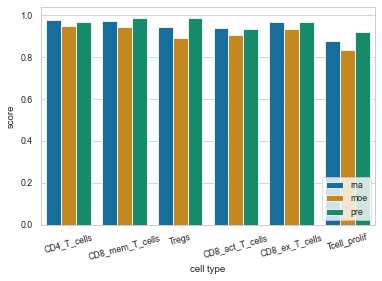

In [8]:
plot = sb.barplot(data=results_bcc[results_bcc['metric']=='R_squared'], y='score', x='cell type', hue='model')
plot.set_xticklabels(plot.get_xticklabels(), rotation=15)
plot.legend(loc='lower right')

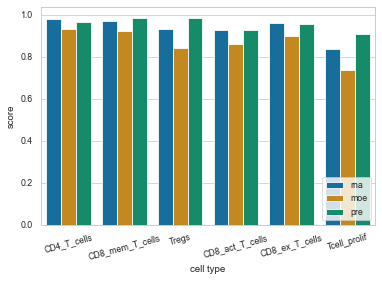

In [9]:
plot = sb.barplot(data=results_bcc[results_bcc['metric']=='R_squared_top_100'], y='score', x='cell type', hue='model')
plot.set_xticklabels(plot.get_xticklabels(), rotation=15)
plot.legend(loc='lower right')

### UMAPS BCC

... storing 'patient' as categorical
... storing 'treatment' as categorical
... storing 'cluster' as categorical
... storing 'source' as categorical
... storing 'pre_post_pred' as categorical


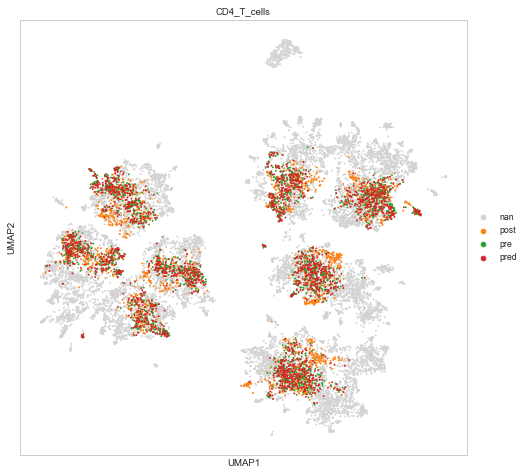

... storing 'patient' as categorical
... storing 'treatment' as categorical
... storing 'cluster' as categorical
... storing 'source' as categorical
... storing 'pre_post_pred' as categorical


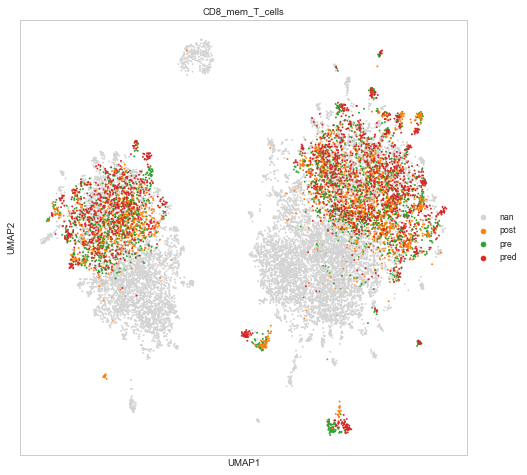

... storing 'patient' as categorical
... storing 'treatment' as categorical
... storing 'cluster' as categorical
... storing 'source' as categorical
... storing 'pre_post_pred' as categorical


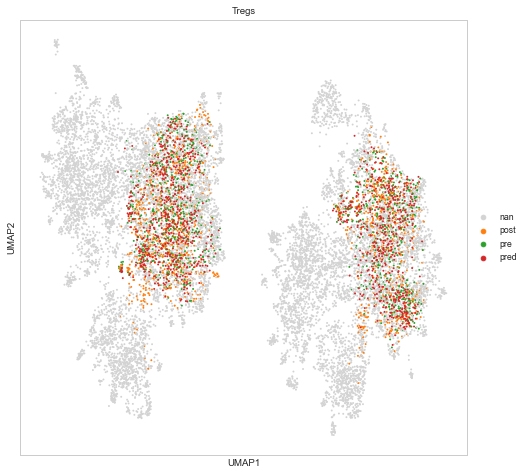

... storing 'patient' as categorical
... storing 'treatment' as categorical
... storing 'cluster' as categorical
... storing 'source' as categorical
... storing 'pre_post_pred' as categorical


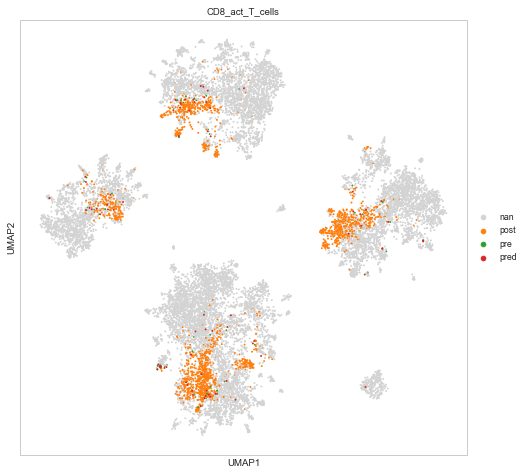

... storing 'patient' as categorical
... storing 'treatment' as categorical
... storing 'cluster' as categorical
... storing 'source' as categorical
... storing 'pre_post_pred' as categorical


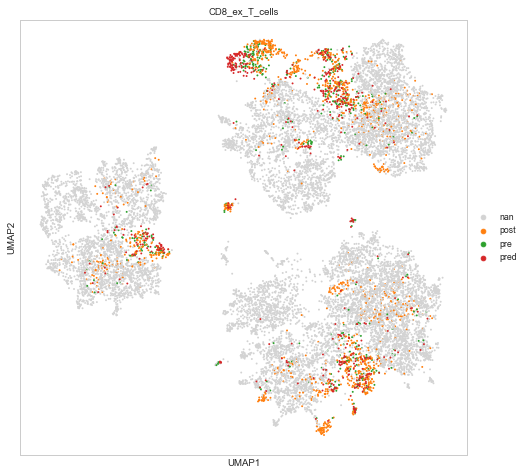

... storing 'patient' as categorical
... storing 'treatment' as categorical
... storing 'cluster' as categorical
... storing 'source' as categorical
... storing 'pre_post_pred' as categorical


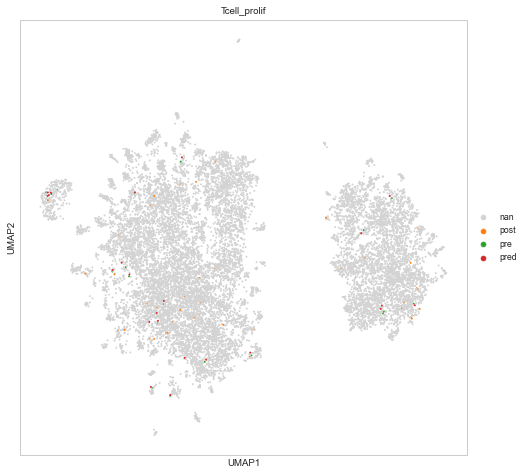

In [24]:
rcParams['figure.figsize'] = (8, 8)

dataset = 'bcc'
model_name = 'moe'

for ct in cell_type_names:
    data = load_modulation_data(dataset)
    model = load_model(data, dataset, model_name, ct)
    latent = model.get_latent(data, metadata=['patient', 'treatment', 'cluster'])

    mask_train = latent.obs['cluster'] != ct
    latent_train = latent[mask_train]
    latent_val = latent[~mask_train]
    
    
    mask_val_pre = latent_val.obs['treatment'] == 'pre'
    latent_val_pre = latent_val[mask_val_pre]
    pred_val_post = predict_pertubation(latent_train, latent_val_pre, model, 'treatment', 'pre',
                                        var_names=data.var_names, return_latent=True)
    
    pred_val_post.obs['source'] = 'predicted'
    pred_val_post.obs['treatment'] = 'pred'
    pred_val_post.obs['cluster'] = ct
    
    latent.obs['source'] = 'measured'
    data_joint = latent.concatenate(pred_val_post)
    
    sc.pp.neighbors(data_joint)
    sc.tl.umap(data_joint)

    data_joint.obs['pred'] = (data_joint.obs['cluster']==ct) & (data_joint.obs['source']=='predicted')
    data_joint.obs['post'] = (data_joint.obs['cluster']==ct) & (data_joint.obs['source']!='predicted') & (data_joint.obs['treatment']=='post')
    data_joint.obs['pre'] = (data_joint.obs['cluster']==ct) & (data_joint.obs['source']!='predicted') & (data_joint.obs['treatment']=='pre')
    data_joint.obs['pre_post_pred'] = 'nan'
    data_joint.obs.loc[data_joint.obs['pre'], 'pre_post_pred'] = 'pre'
    data_joint.obs.loc[data_joint.obs['post'], 'pre_post_pred'] = 'post'
    data_joint.obs.loc[data_joint.obs['pred'], 'pre_post_pred'] = 'pred'
    
    sc.pl.umap(data_joint, color=['pre_post_pred'], size=15,
               palette={'nan': 'lightgray', 'pre': 'tab:green', 'pred': 'tab:red', 'post': 'tab:orange'},
               title=ct)


In [11]:
sc.tl.rank_genes_groups(data, 'cluster', n_genes=100, method='wilcoxon')
degs = data.uns['rank_genes_groups']['names']

... storing 'source' as categorical


In [12]:
degs_tmp = [j for i in degs for j in i]
degs_tmp

['RPLP0',
 'JUNB',
 'CXCL13',
 'LITAF',
 'STMN1',
 'FOXP3',
 'KLRB1',
 'SLC2A3',
 'DUSP4',
 'DUSP2',
 'HMGN2',
 'CARD16',
 'TPT1',
 'CD69',
 'AHI1',
 'GZMK',
 'HMGB2',
 'HTATIP2',
 'MT2A',
 'IER2',
 'TIGIT',
 'CST7',
 'RRM2',
 'BATF',
 'MT1X',
 'JUN',
 'NR3C1',
 'CXCR4',
 'H2AFZ',
 'IL32',
 'RPS18',
 'CCL5',
 'PDE7B',
 'LDHA',
 'MKI67',
 'TBC1D4',
 'IL7R',
 'NR4A2',
 'TNFRSF18',
 'CD8A',
 'TUBA1B',
 'TNFRSF4',
 'MT1F',
 'GADD45B',
 'ENTPD1',
 'CCL5',
 'TUBB',
 'TIGIT',
 'RPS12',
 'DUSP1',
 'ZBED2',
 'NKG7',
 'PFN1',
 'LTB',
 'MT1E',
 'FOS',
 'SRGN',
 'PIK3R1',
 'TYMS',
 'SAT1',
 'TNFRSF25',
 'UBC',
 'NAP1L4',
 'AOAH',
 'DUT',
 'GK',
 'CTSH',
 'HLA-DPB1',
 'HLA-A',
 'GGA2',
 'ACTB',
 'TNFRSF18',
 'RORA',
 'HSPA1B',
 'RGS2',
 'OASL',
 'CKS1B',
 'CTLA4',
 'GIMAP7',
 'IFNG',
 'SNX9',
 'ZFP36',
 'TOP2A',
 'IKZF2',
 'MGAT4A',
 'MT-ND4',
 'PDE3B',
 'SH2D2A',
 'NUSAP1',
 'MIR4435-2HG',
 'RPS8',
 'NFKBIA',
 'GNG4',
 'APMAP',
 'CCNA2',
 'CD27',
 'TNFAIP8',
 'GZMA',
 'ADGRG1',
 'LCP1',
 'TK1',
 '

In [23]:
adata = load_modulation_data('bcc')
adata.obs.groupby('treatment')['cluster'].value_counts()

treatment  cluster        
post       CD8_mem_T_cells    2028
           CD8_act_T_cells    1890
           CD4_T_cells        1869
           CD8_ex_T_cells     1406
           Tregs              1377
           Tcell_prolif         53
pre        CD8_mem_T_cells    2057
           CD4_T_cells        2033
           Tregs              1115
           CD8_ex_T_cells      520
           CD8_act_T_cells      79
           Tcell_prolif         23
Name: cluster, dtype: int64

In [1]:
def scp_cmd(dataset, model, trial, clone):
    cmd = f'scp -i ~/.ssh/drost_cluster_juelich drost1@juwels-booster.fz-juelich.de:'
    cmd += f'/p/project/hai_sctc_can/code/optuna/scGen_rev_{dataset}_{clone}_{model}/trial_{trial}/'
    cmd += 'best_model_by_metric.pt '
    cmd += f'/c/Daten/Projects/TcrTranscriptome/saved_models/journal/BCC_clone_rev/{model}/'
    cmd += f'scGen_bcc_{clone}_{model}.pt'
    return cmd

In [2]:
trials_bcc_moe = {
    5916: 20,
    5933: 26,
    7675: 26,
    5910: 15,
    2117: 25,
    5912: 15,
    5977: 22,
    4746: 24,
    5909: 26,
    7660: 24,
}

In [3]:
for ct, t in trials_bcc_moe.items():
    print(scp_cmd('bcc', 'moe', t, ct))
    print('1Legion4u')
    print()

scp -i ~/.ssh/drost_cluster_juelich drost1@juwels-booster.fz-juelich.de:/p/project/hai_sctc_can/code/optuna/scGen_rev_bcc_5916_moe/trial_20/best_model_by_metric.pt /c/Daten/Projects/TcrTranscriptome/saved_models/journal/BCC_clone_rev/moe/scGen_bcc_5916_moe.pt
1Legion4u

scp -i ~/.ssh/drost_cluster_juelich drost1@juwels-booster.fz-juelich.de:/p/project/hai_sctc_can/code/optuna/scGen_rev_bcc_5933_moe/trial_26/best_model_by_metric.pt /c/Daten/Projects/TcrTranscriptome/saved_models/journal/BCC_clone_rev/moe/scGen_bcc_5933_moe.pt
1Legion4u

scp -i ~/.ssh/drost_cluster_juelich drost1@juwels-booster.fz-juelich.de:/p/project/hai_sctc_can/code/optuna/scGen_rev_bcc_7675_moe/trial_26/best_model_by_metric.pt /c/Daten/Projects/TcrTranscriptome/saved_models/journal/BCC_clone_rev/moe/scGen_bcc_7675_moe.pt
1Legion4u

scp -i ~/.ssh/drost_cluster_juelich drost1@juwels-booster.fz-juelich.de:/p/project/hai_sctc_can/code/optuna/scGen_rev_bcc_5910_moe/trial_15/best_model_by_metric.pt /c/Daten/Projects/TcrTr

In [4]:
trials_bcc_rna = {
    5916: 21,
    5933: 24,
    7675: 15,
    5910: 7,
    2117: 6,
    5912: 19,
    5977: 29,
    4746: 20,
    5909: 29,
    7660: 25,
}

In [5]:
for ct, t in trials_bcc_rna.items():
    print(scp_cmd('bcc', 'rna', t, ct))
    print('1Legion4u')
    print()

scp -i ~/.ssh/drost_cluster_juelich drost1@juwels-booster.fz-juelich.de:/p/project/hai_sctc_can/code/optuna/scGen_rev_bcc_5916_rna/trial_21/best_model_by_metric.pt /c/Daten/Projects/TcrTranscriptome/saved_models/journal/BCC_clone_rev/rna/scGen_bcc_5916_rna.pt
1Legion4u

scp -i ~/.ssh/drost_cluster_juelich drost1@juwels-booster.fz-juelich.de:/p/project/hai_sctc_can/code/optuna/scGen_rev_bcc_5933_rna/trial_24/best_model_by_metric.pt /c/Daten/Projects/TcrTranscriptome/saved_models/journal/BCC_clone_rev/rna/scGen_bcc_5933_rna.pt
1Legion4u

scp -i ~/.ssh/drost_cluster_juelich drost1@juwels-booster.fz-juelich.de:/p/project/hai_sctc_can/code/optuna/scGen_rev_bcc_7675_rna/trial_15/best_model_by_metric.pt /c/Daten/Projects/TcrTranscriptome/saved_models/journal/BCC_clone_rev/rna/scGen_bcc_7675_rna.pt
1Legion4u

scp -i ~/.ssh/drost_cluster_juelich drost1@juwels-booster.fz-juelich.de:/p/project/hai_sctc_can/code/optuna/scGen_rev_bcc_5910_rna/trial_7/best_model_by_metric.pt /c/Daten/Projects/TcrTra